In [2]:
# imports
import os
os.sys.path.append(os.path.abspath(".."))

import tensorflow as tf

import random

from copy import deepcopy

import pandas as pd
import numpy as np

import keras

from matplotlib import pyplot as plt

import json

import notebooks_utils.analysis as utils
from notebooks_utils import visuals

from IPython.display import display

import project.download_content as content

METAPATH = os.path.join(content.DATAPATH, 'METADATA')


from keras.applications import VGG19, VGG16
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input as preprocess_19
from keras.applications.vgg16 import preprocess_input as preprocess_16
from keras.models import Model

from keras import backend as K
from keras import layers
from keras.optimizers import Adam, SGD

import swifter

import dask.dataframe as dd
import multiprocessing

from project.model.ssd_model_300 import ssd_model_300
from project.model.ssd_model_624 import ssd_model_624
from project.model.loss import SSDloss
from project.model.iou import iou
from project.model.smooth_l1 import smooth_l1

In [3]:
df = pd.read_csv(METAPATH + '/enriched_train_bbox.csv')
display(df.head(5))

boats = df.query("LabelSemantic == 'Boat'")
display(boats.head(2))

boats.shape

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Path,LabelSemantic,cx,cy,w,h
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0,data/TRAIN/train_0/000002b66c9c498e.jpg,Person,0.103906,0.367969,0.182812,0.439062
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0,data/TRAIN/train_0/000002b66c9c498e.jpg,Person,0.150781,0.831250,0.251563,0.234375
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0,data/TRAIN/train_0/000002b66c9c498e.jpg,Person,0.231249,0.394531,0.159375,0.392188
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0,data/TRAIN/train_0/000002b66c9c498e.jpg,Person,0.342969,0.788282,0.173438,0.273437
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0,data/TRAIN/train_0/000002b66c9c498e.jpg,Person,0.302343,0.310938,0.089063,0.150000


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Path,LabelSemantic,cx,cy,w,h
78,00001bc2c4027449,xclick,/m/019jd,1,0.2675,0.765000,0.240833,0.8025,1,0,0,0,0,data/TRAIN/train_0/00001bc2c4027449.jpg,Boat,0.516250,0.521667,0.497500,0.561667
1208,0000c035a08c3770,xclick,/m/019jd,1,0.0000,0.996248,0.000000,0.9725,1,1,0,0,0,data/TRAIN/train_0/0000c035a08c3770.jpg,Boat,0.498124,0.486250,0.996248,0.972500


(79113, 19)

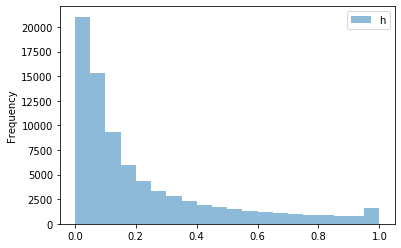

In [4]:
# plot the bounding boxes width
bs = boats.sort_values(by='h')
bs[['h']].plot.hist(bins=20, alpha=0.5)

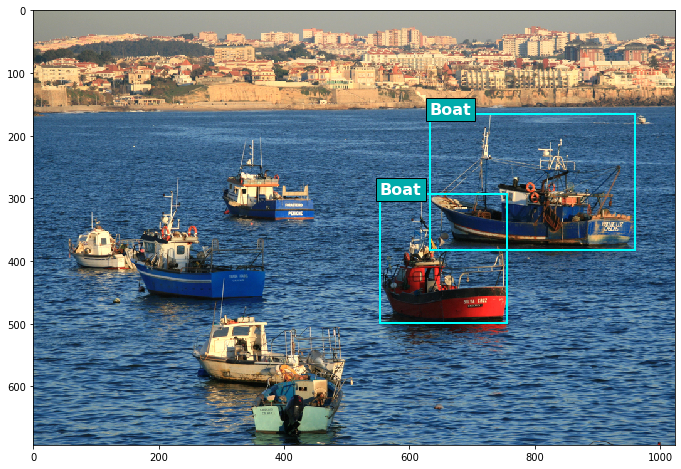

In [5]:
sample_img = boats.iloc[421]
img = image.load_img(sample_img.Path)

plt.figure(figsize=(12,8))
plt.imshow(img)

visuals.draw_bbox(img, sample_img)
visuals.draw_bbox(img, boats.iloc[420])

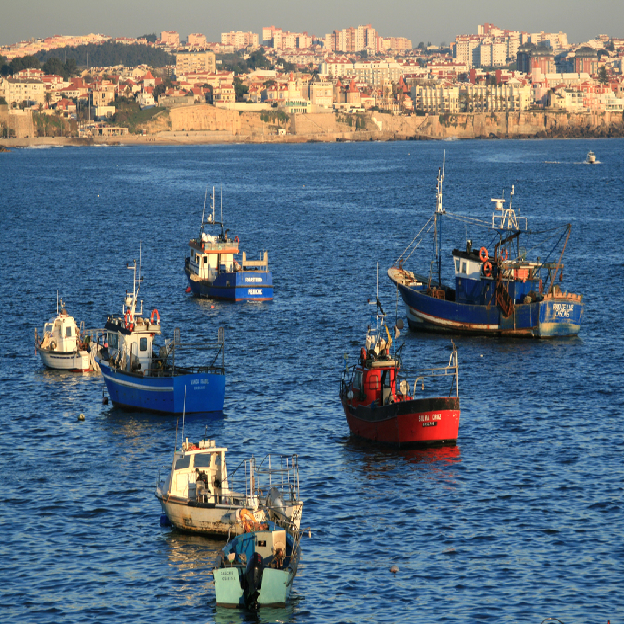

In [6]:
# Preprocessing the image
img = image.load_img(boats.iloc[421].Path, target_size=(624, 624))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

display(image.array_to_img(x[0]))

px = preprocess_16(x)

## model

The model has 7 layers to draw the bounding_boxes, they were called as `number_bbs`

in each layer there are some types of bouding boxes, specified as follow:

|         | number of regions | size of filter in pixels | ratios w/h          | number of bounding boxes |
|---------|-------------------|--------------------------|---------------------|--------------------------|
| 1st_bbs | 5776              | 24px/24px                | [1, 1/2, 2]         | 17328                    |
| 2nd_bbs | 1369              | 48px/48px                | [1, 1/2, 2]         | 4107                     |
| 3rd_bbs | 289               | 98px/98px                | [1, 1/2, 1/3, 2, 3] | 1445                     |
| 4th_bbs | 49                | 208px/208px              | [1, 1/2, 1/3, 2, 3] | 245                      |
| 5th_bbs | 25                | 267px/267px              | [1, 1/2, 1/3, 2, 3] | 125                      |
| 6th_bbs | 9                 | 374px/374px              | [1, 1/2, 1/3, 2, 3] | 45                       |
| 7th_bbs | 1                 | 623px/624px              | [1, 1/2, 1/3, 2, 3] | 5                        |

In [7]:
model = ssd_model_300()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 300, 300, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 150, 150, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

/home/bruno/projetos/capstone-udacity-mle/project/model/ssd_model_300.py:111: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`



In [8]:
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)
# sgd = SGD(lr=0.01)

sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
ssd_loss = SSDloss()
model.compile(optimizer=sgd, loss=ssd_loss.loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Constructing the bboxs

In [9]:
def bbox(sizes, stride=1, ratios=None):
    arr = []
    for n in sizes:
        e = 1 / n
        
        t = e*3
        
        for i in range(0, n-2, stride):
            for j in range(0, n-2, stride):
                arr.append([e*(i+3/2), e*(j+3/2), t, t])
                
                for r in ratios:
                    arr.append([e*(i+3/2), e*(j+3/2), t*r, t])
                for r in ratios:
                    arr.append([e*(i+3/2), e*(j+3/2), t, t*r])
    return pd.DataFrame(arr, columns=['cx', 'cy', 'w', 'h'])

## ssd624
# refs_s2 = bbox([157, 79], stride=2, ratios=[1/2])
# refs_s1 = bbox([21,11,9,7,5,3], stride=1, ratios=[1/2, 1/3])

refs_s2 = bbox([75, 39], stride=2, ratios=[1/2])
refs_s1 = bbox([11,7,5,3], stride=1, ratios=[1/2, 1/3])

refs = pd.concat([refs_s2, refs_s1]).reset_index()[['cx', 'cy', 'w', 'h']]
refs.shape

(5770, 4)

In [10]:
def identify_bbox(row):
    row = row[['cx', 'cy', 'w', 'h']]
    ious = iou(row.values, refs.values)
    ious[ious < 0.5] = 0
    
    bboxs = np.where((ious == np.amax(ious)) & (ious > 0))[0]
#     if bboxs.size > 0:
#         return bboxs[0]
#     return None
    return bboxs

In [11]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    boats['bbox_ref'] = (dd.from_pandas(boats, npartitions=multiprocessing.cpu_count())
                           .map_partitions(lambda df: df.apply(identify_bbox, axis=1))
                           .compute(scheduler='processes'))

[########################################] | 100% Completed |  1min 23.7s


/home/bruno/.virtualenvs/ml-tf1.15/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



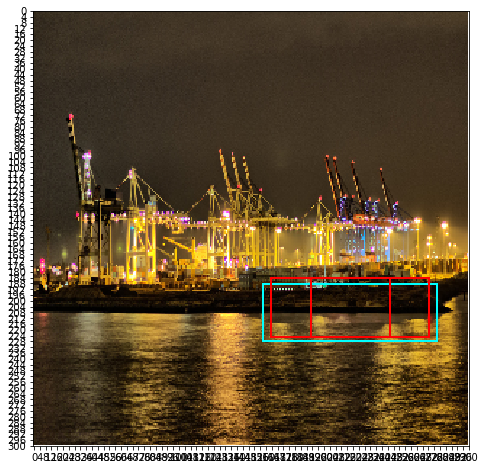

In [12]:
boat_ref = 2663
sample_img = boats.loc[boat_ref]

bboxs_found = identify_bbox(sample_img)

img = image.load_img(sample_img.Path, target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img)
# plt.grid()
plt.xticks(range(0, 301, int(300/75)))
plt.yticks(range(0, 301, int(300/75)))

visuals.draw_bbox(img, sample_img, legend=False)

for bbox_found in bboxs_found:
    test = refs.iloc[bbox_found]
    test['LabelSemantic'] = 'teste'
    visuals.draw_bbox(img, test, legend=False, color="#ff0000")

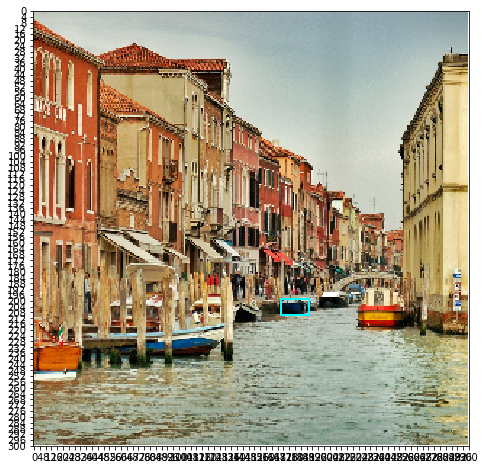

In [13]:
boat_ref = 11408536
sample_img = boats.loc[boat_ref]

bboxs_found = identify_bbox(sample_img)

img = image.load_img(sample_img.Path, target_size=(300, 300))

plt.figure(figsize=(12,8))
plt.imshow(img)
# plt.grid()
plt.xticks(range(0, 301, int(300/75)))
plt.yticks(range(0, 301, int(300/75)))

visuals.draw_bbox(img, sample_img, legend=False)

for bbox_found in bboxs_found:
    test = refs.iloc[bbox_found]
    test['LabelSemantic'] = 'teste'
    visuals.draw_bbox(img, test, legend=False, color="#ff0000")

In [14]:
i = boats[boats.bbox_ref.apply(lambda x: len(x) > 0)].index
display(boats.loc[i].shape)

boats.loc[i].sample(5)

(41337, 20)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,Path,LabelSemantic,cx,cy,w,h,bbox_ref
3336995,36b12f5438639b1f,xclick,/m/019jd,1,0.357500,0.758125,0.410161,0.843866,1,0,0,0,0,data/TRAIN/train_3/36b12f5438639b1f.jpg,Boat,0.557813,0.627014,0.400625,0.433705,[5660]
1046802,0f3c07b214e6d6b4,xclick,/m/019jd,1,0.000000,0.983750,0.450000,0.999167,1,1,1,0,0,data/TRAIN/train_0/0f3c07b214e6d6b4.jpg,Boat,0.491875,0.724584,0.983750,0.549167,"[5730, 5745]"
3506062,39a5ce7a76e70d0a,xclick,/m/019jd,1,0.282152,0.615486,0.257485,0.736527,1,0,0,0,0,data/TRAIN/train_3/39a5ce7a76e70d0a.jpg,Boat,0.448819,0.497006,0.333334,0.479042,[5655]
9338605,9f488d2226fa253a,activemil,/m/019jd,1,0.156250,1.000000,0.079805,0.982085,1,1,0,0,0,data/TRAIN/train_9/9f488d2226fa253a.jpg,Boat,0.578125,0.530945,0.843750,0.902280,[5765]
5787696,615945d9cd9c3d14,activemil,/m/019jd,1,0.396875,0.640625,0.568333,0.966667,0,0,0,0,0,data/TRAIN/train_6/615945d9cd9c3d14.jpg,Boat,0.518750,0.767500,0.243750,0.398334,[5666]


## Training

In [15]:
%%time
imgs = boats[['ImageID', 'Path']].drop_duplicates()
imgs.set_index('ImageID', inplace=True)

for c in ['cx', 'cy', 'w', 'h', 'bbox_ref']:
    imgs = imgs.join(boats.groupby('ImageID')[c].apply(list))

imgs.reset_index(inplace=True)
imgs.shape

CPU times: user 6.9 s, sys: 13.8 ms, total: 6.92 s
Wall time: 6.92 s


(25478, 7)

In [16]:
display(imgs.sample(3, random_state=1))
display(imgs.loc[10418])

,ImageID,Path,cx,cy,w,h,bbox_ref
23856,ee330677a7fbb697,data/TRAIN/train_e/ee330677a7fbb697.jpg,[0.5396875],[0.567098],[0.26062500000000005],[0.427112],[[5741]]
23949,ef65017b3a712e08,data/TRAIN/train_e/ef65017b3a712e08.jpg,[0.3375],[0.6608065000000001],[0.25625],[0.024870999999999976],[[]]
8625,52b2b98ff5d0e8d4,data/TRAIN/train_5/52b2b98ff5d0e8d4.jpg,[0.38],[0.4758335],[0.6975],[0.648333],[[5725]]


ImageID                                      65cb79f49738b2b8
Path                  data/TRAIN/train_6/65cb79f49738b2b8.jpg
cx          [0.493125, 0.156875, 0.263125, 0.281875, 0.769...
cy          [0.5433330000000001, 0.30125, 0.495, 0.48375, ...
w           [0.24875000000000005, 0.31375, 0.03125, 0.0374...
h           [0.5650000000000001, 0.6025, 0.056666000000000...
bbox_ref    [[5741], [5595, 5600], [1053], [], [3164], [],...
Name: 10418, dtype: object

In [17]:
import math

target = np.zeros((imgs.shape[0], refs.shape[0], model.output.shape[-1]), dtype=np.float32)
target[:][:] = [1,0,0,0,0,0]

for i, r in imgs.iterrows():
    for cx, cy, w, h, refs in zip(r.cx, r.cy, r.w, r.h, r.bbox_ref):
        for ref in refs: 
            target[i][int(ref)] = [0, 1, cx, cy, w, h]
        
target.shape

(25478, 5770, 6)

In [18]:
def gen_data():
    while True:
        for i, y in enumerate(target):
            img_path = imgs.iloc[i].Path
            img = image.load_img(img_path, target_size=(300, 300))
            X = image.img_to_array(img)

            X = np.expand_dims(X, axis=0)
            y = np.expand_dims(y, axis=0)

            yield X, y

In [ ]:
model.fit_generator(gen_data(), steps_per_epoch=4, epochs=6500)


Epoch 1/6500
4/4 [==============================] - 2s 568ms/step - loss: 7060741.1250
Epoch 2/6500
4/4 [==============================] - 0s 24ms/step - loss: 2960394.0000
Epoch 3/6500
4/4 [==============================] - 0s 24ms/step - loss: 1480019.7188
Epoch 4/6500
4/4 [==============================] - 0s 24ms/step - loss: 3269931.4844
Epoch 5/6500
4/4 [==============================] - 0s 24ms/step - loss: 2600827.0625
Epoch 6/6500
4/4 [==============================] - 0s 24ms/step - loss: 988008.5312
Epoch 7/6500
4/4 [==============================] - 0s 25ms/step - loss: 2293464.6875
Epoch 8/6500
4/4 [==============================] - 0s 25ms/step - loss: 1130454.8750
Epoch 9/6500
4/4 [==============================] - 0s 24ms/step - loss: 1244086.4062
Epoch 10/6500
4/4 [==============================] - 0s 24ms/step - loss: 830792.7500
Epoch 11/6500
4/4 [==============================] - 0s 23ms/step - loss: 3187699.2188
Epoch 12/6500
4/4 [==============================] -

4/4 [==============================] - 0s 23ms/step - loss: 826151.4844
Epoch 94/6500
4/4 [==============================] - 0s 24ms/step - loss: 1160969.9688
Epoch 95/6500
4/4 [==============================] - 0s 23ms/step - loss: 939389.4062
Epoch 96/6500
4/4 [==============================] - 0s 23ms/step - loss: 713516.6641
Epoch 97/6500
4/4 [==============================] - 0s 22ms/step - loss: 1808319.5781
Epoch 98/6500
4/4 [==============================] - 0s 24ms/step - loss: 764562.4766
Epoch 99/6500
4/4 [==============================] - 0s 23ms/step - loss: 466937.8125
Epoch 100/6500
4/4 [==============================] - 0s 23ms/step - loss: 1675114.4570
Epoch 101/6500
4/4 [==============================] - 0s 22ms/step - loss: 1230558.8359
Epoch 102/6500
4/4 [==============================] - 0s 22ms/step - loss: 538423.2656
Epoch 103/6500
4/4 [==============================] - 0s 23ms/step - loss: 610159.1953
Epoch 104/6500
4/4 [==============================] - 0s 22m

4/4 [==============================] - 0s 23ms/step - loss: 1968072.4688
Epoch 187/6500
4/4 [==============================] - 0s 24ms/step - loss: 1274643.6719
Epoch 188/6500
4/4 [==============================] - 0s 23ms/step - loss: 662351.7500
Epoch 189/6500
4/4 [==============================] - 0s 23ms/step - loss: 775824.2812
Epoch 190/6500
4/4 [==============================] - 0s 23ms/step - loss: 764478.0938
Epoch 191/6500
4/4 [==============================] - 0s 23ms/step - loss: 1438074.7734
Epoch 192/6500
4/4 [==============================] - 0s 23ms/step - loss: 570904.7812
Epoch 193/6500
4/4 [==============================] - 0s 23ms/step - loss: 792345.7891
Epoch 194/6500
4/4 [==============================] - 0s 23ms/step - loss: 1042720.2344
Epoch 195/6500
4/4 [==============================] - 0s 23ms/step - loss: 826114.2969
Epoch 196/6500
4/4 [==============================] - 0s 24ms/step - loss: 432405.2969
Epoch 197/6500
4/4 [==============================] - 

4/4 [==============================] - 0s 23ms/step - loss: 596587.2656
Epoch 280/6500
4/4 [==============================] - 0s 23ms/step - loss: 360434.4453
Epoch 281/6500
4/4 [==============================] - 0s 23ms/step - loss: 205719.7422
Epoch 282/6500
4/4 [==============================] - 0s 24ms/step - loss: 344945.9844
Epoch 283/6500
4/4 [==============================] - 0s 22ms/step - loss: 878971.5156
Epoch 284/6500
4/4 [==============================] - 0s 25ms/step - loss: 366696.8945
Epoch 285/6500
4/4 [==============================] - 0s 23ms/step - loss: 506344.2812
Epoch 286/6500
4/4 [==============================] - 0s 23ms/step - loss: 626719.2500
Epoch 287/6500
4/4 [==============================] - 0s 23ms/step - loss: 442552.0000
Epoch 288/6500
4/4 [==============================] - 0s 22ms/step - loss: 1535579.2031
Epoch 289/6500
4/4 [==============================] - 0s 24ms/step - loss: 533345.8555
Epoch 290/6500
4/4 [==============================] - 0s 

4/4 [==============================] - 0s 24ms/step - loss: 609190.0547
Epoch 374/6500
4/4 [==============================] - 0s 23ms/step - loss: 913780.0938
Epoch 375/6500
4/4 [==============================] - 0s 22ms/step - loss: 881571.2500
Epoch 376/6500
4/4 [==============================] - 0s 23ms/step - loss: 302074.9375
Epoch 377/6500
4/4 [==============================] - 0s 24ms/step - loss: 1902627.5625
Epoch 378/6500
4/4 [==============================] - 0s 24ms/step - loss: 1064975.3438
Epoch 379/6500
4/4 [==============================] - 0s 24ms/step - loss: 1760162.9141
Epoch 380/6500
4/4 [==============================] - 0s 23ms/step - loss: 1546935.8438
Epoch 381/6500
4/4 [==============================] - 0s 23ms/step - loss: 924821.0000
Epoch 382/6500
4/4 [==============================] - 0s 23ms/step - loss: 1739184.7344
Epoch 383/6500
4/4 [==============================] - 0s 23ms/step - loss: 861643.7344
Epoch 384/6500
4/4 [==============================] -

4/4 [==============================] - 0s 23ms/step - loss: 1124189.8125
Epoch 467/6500
4/4 [==============================] - 0s 23ms/step - loss: 697999.5781
Epoch 468/6500
4/4 [==============================] - 0s 23ms/step - loss: 1615377.3438
Epoch 469/6500
4/4 [==============================] - 0s 24ms/step - loss: 1220817.0234
Epoch 470/6500
4/4 [==============================] - 0s 24ms/step - loss: 673445.4922
Epoch 471/6500
4/4 [==============================] - 0s 23ms/step - loss: 613313.4062
Epoch 472/6500
4/4 [==============================] - 0s 23ms/step - loss: 1261446.5938
Epoch 473/6500
4/4 [==============================] - 0s 23ms/step - loss: 682755.9531
Epoch 474/6500
4/4 [==============================] - 0s 23ms/step - loss: 1046771.9375
Epoch 475/6500
4/4 [==============================] - 0s 23ms/step - loss: 547424.4922
Epoch 476/6500
4/4 [==============================] - 0s 23ms/step - loss: 599289.3789
Epoch 477/6500
4/4 [==============================] -

4/4 [==============================] - 0s 23ms/step - loss: 9878009.7500
Epoch 560/6500
4/4 [==============================] - 0s 24ms/step - loss: 1715535.7500
Epoch 561/6500
4/4 [==============================] - 0s 23ms/step - loss: 2672090.2500
Epoch 562/6500
4/4 [==============================] - 0s 23ms/step - loss: 2890944.5000
Epoch 563/6500
4/4 [==============================] - 0s 23ms/step - loss: 4228405.5625
Epoch 564/6500
4/4 [==============================] - 0s 23ms/step - loss: 2139135.4375
Epoch 565/6500
4/4 [==============================] - 0s 22ms/step - loss: 4069636.1250
Epoch 566/6500
4/4 [==============================] - 0s 23ms/step - loss: 1036918.3906
Epoch 567/6500
4/4 [==============================] - 0s 22ms/step - loss: 1821615.2500
Epoch 568/6500
4/4 [==============================] - 0s 23ms/step - loss: 2474945.2500
Epoch 569/6500
4/4 [==============================] - 0s 23ms/step - loss: 2700831.1719
Epoch 570/6500
4/4 [===========================

4/4 [==============================] - 0s 24ms/step - loss: 346691.4219
Epoch 653/6500
4/4 [==============================] - 0s 23ms/step - loss: 153207.6992
Epoch 654/6500
4/4 [==============================] - 0s 24ms/step - loss: 420167.7539
Epoch 655/6500
4/4 [==============================] - 0s 24ms/step - loss: 368886.1367
Epoch 656/6500
4/4 [==============================] - 0s 23ms/step - loss: 383490.4336
Epoch 657/6500
4/4 [==============================] - 0s 23ms/step - loss: 947050.1875
Epoch 658/6500
4/4 [==============================] - 0s 23ms/step - loss: 700917.4844
Epoch 659/6500
4/4 [==============================] - 0s 23ms/step - loss: 772450.8828
Epoch 660/6500
4/4 [==============================] - 0s 24ms/step - loss: 876918.8672
Epoch 661/6500
4/4 [==============================] - 0s 22ms/step - loss: 372585.3281
Epoch 662/6500
4/4 [==============================] - 0s 23ms/step - loss: 615132.5000
Epoch 663/6500
4/4 [==============================] - 0s 2

Epoch 746/6500
4/4 [==============================] - 0s 23ms/step - loss: 899830.1328
Epoch 747/6500
4/4 [==============================] - 0s 23ms/step - loss: 1450084.9473
Epoch 748/6500
4/4 [==============================] - 0s 23ms/step - loss: 998531.7031
Epoch 749/6500
4/4 [==============================] - 0s 23ms/step - loss: 1057721.7812
Epoch 750/6500
4/4 [==============================] - 0s 23ms/step - loss: 351328.4297
Epoch 751/6500
4/4 [==============================] - 0s 22ms/step - loss: 572438.6250
Epoch 752/6500
4/4 [==============================] - 0s 23ms/step - loss: 592728.0469
Epoch 753/6500
4/4 [==============================] - 0s 23ms/step - loss: 501733.2969
Epoch 754/6500
4/4 [==============================] - 0s 23ms/step - loss: 740126.0469
Epoch 755/6500
4/4 [==============================] - 0s 22ms/step - loss: 443497.5938
Epoch 756/6500
4/4 [==============================] - 0s 23ms/step - loss: 950831.8125
Epoch 757/6500
4/4 [=====================

4/4 [==============================] - 0s 24ms/step - loss: 475607.0938
Epoch 840/6500
4/4 [==============================] - 0s 23ms/step - loss: 462311.6094
Epoch 841/6500
4/4 [==============================] - 0s 24ms/step - loss: 619995.9688
Epoch 842/6500
4/4 [==============================] - 0s 23ms/step - loss: 600913.4609
Epoch 843/6500
4/4 [==============================] - 0s 23ms/step - loss: 689071.0312
Epoch 844/6500
4/4 [==============================] - 0s 24ms/step - loss: 647011.6797
Epoch 845/6500
4/4 [==============================] - 0s 23ms/step - loss: 372141.2500
Epoch 846/6500
4/4 [==============================] - 0s 23ms/step - loss: 589677.6562
Epoch 847/6500
4/4 [==============================] - 0s 23ms/step - loss: 614700.9062
Epoch 848/6500
4/4 [==============================] - 0s 23ms/step - loss: 263027.4766
Epoch 849/6500
4/4 [==============================] - 0s 23ms/step - loss: 293578.2891
Epoch 850/6500
4/4 [==============================] - 0s 2

4/4 [==============================] - 0s 24ms/step - loss: 1876143.1875
Epoch 933/6500
4/4 [==============================] - 0s 24ms/step - loss: 26289504.2500
Epoch 934/6500
4/4 [==============================] - 0s 22ms/step - loss: 4893470.8750
Epoch 935/6500
4/4 [==============================] - 0s 23ms/step - loss: 16749195.6250
Epoch 936/6500
4/4 [==============================] - 0s 23ms/step - loss: 2951516.5000
Epoch 937/6500
4/4 [==============================] - 0s 23ms/step - loss: 10436892.8750
Epoch 938/6500
4/4 [==============================] - 0s 24ms/step - loss: 20845796.6250
Epoch 939/6500
4/4 [==============================] - 0s 23ms/step - loss: 3383938.0000
Epoch 940/6500
4/4 [==============================] - 0s 23ms/step - loss: 3307293.1875
Epoch 941/6500
4/4 [==============================] - 0s 23ms/step - loss: 2184720.2188
Epoch 942/6500
4/4 [==============================] - 0s 23ms/step - loss: 2968301.6875
Epoch 943/6500
4/4 [=======================

4/4 [==============================] - 0s 23ms/step - loss: 681643.6641
Epoch 1026/6500
4/4 [==============================] - 0s 23ms/step - loss: 791636.1641
Epoch 1027/6500
4/4 [==============================] - 0s 23ms/step - loss: 750507.1875
Epoch 1028/6500
4/4 [==============================] - 0s 22ms/step - loss: 718733.7969
Epoch 1029/6500
4/4 [==============================] - 0s 23ms/step - loss: 759283.6562
Epoch 1030/6500
4/4 [==============================] - 0s 23ms/step - loss: 509740.3047
Epoch 1031/6500
4/4 [==============================] - 0s 23ms/step - loss: 308190.3594
Epoch 1032/6500
4/4 [==============================] - 0s 22ms/step - loss: 496719.1562
Epoch 1033/6500
4/4 [==============================] - 0s 23ms/step - loss: 262547.1641
Epoch 1034/6500
4/4 [==============================] - 0s 23ms/step - loss: 651362.8125
Epoch 1035/6500
4/4 [==============================] - 0s 23ms/step - loss: 301195.2930
Epoch 1036/6500
4/4 [===========================

4/4 [==============================] - 0s 23ms/step - loss: 1138334.2344
Epoch 1118/6500
4/4 [==============================] - 0s 23ms/step - loss: 1913936.0312
Epoch 1119/6500
4/4 [==============================] - 0s 23ms/step - loss: 1337308.7656
Epoch 1120/6500
4/4 [==============================] - 0s 23ms/step - loss: 1073521.7734
Epoch 1121/6500
4/4 [==============================] - 0s 22ms/step - loss: 484948.3047
Epoch 1122/6500
4/4 [==============================] - 0s 23ms/step - loss: 501102.6875
Epoch 1123/6500
4/4 [==============================] - 0s 23ms/step - loss: 888301.4375
Epoch 1124/6500
4/4 [==============================] - 0s 23ms/step - loss: 829403.7188
Epoch 1125/6500
4/4 [==============================] - 0s 23ms/step - loss: 909582.9688
Epoch 1126/6500
4/4 [==============================] - 0s 23ms/step - loss: 699733.1250
Epoch 1127/6500
4/4 [==============================] - 0s 23ms/step - loss: 653208.7969
Epoch 1128/6500
4/4 [=======================

In [ ]:
img_path = imgs.iloc[421].Path
img = image.load_img(img_path, target_size=(300, 300))
X = image.img_to_array(img)

p = model.predict(np.expand_dims(X, axis=0))
p.shape

In [37]:
arr = [x for x in p[0] if x[1] > .99]
df_arr = pd.DataFrame(arr, columns=['no-class','boat','cx','cy','w','h'])
df_arr.shape

(1735, 6)

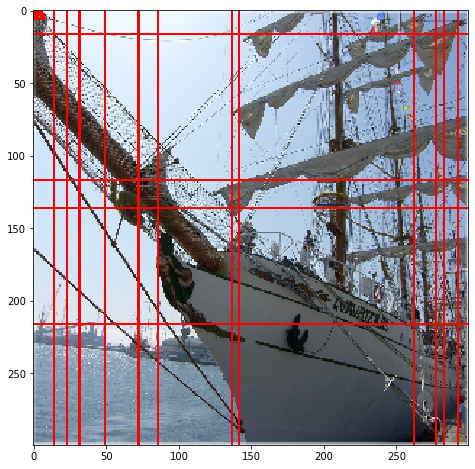

In [35]:
plt.figure(figsize=(12,8))
plt.imshow(img)

# visuals.draw_bbox(img, sample_img, legend=False)

for bbox_found in df_arr.itertuples():
#     test['LabelSemantic'] = 'teste'
    visuals.draw_bbox(img, bbox_found, legend=False, color="#ff0000")